# <center>Домашнее задание № 4 
### <center><font color='blue'>студентки группы ПМ-3, Гонтаренко Яны</font>
## <center>Линейная регрессия: переобучение и регуляризация

В этом задании мы на примерах увидим, как переобучаются линейные модели, разберем, почему так происходит, и выясним, как диагностировать и контролировать переобучение.

Во всех ячейках, где написан комментарий с инструкциями, нужно написать код, выполняющий эти инструкции. Остальные ячейки с кодом (без комментариев) нужно просто выполнить. Кроме того, в задании требуется отвечать на вопросы; ответы нужно вписывать после выделенного слова "__Ответ:__".

Чтобы посмотреть справку любого метода или функции (узнать, какие у нее аргументы и что она делает) можно с помощью комбинации `Shift+Tab`. Нажатие `Tab` после имени объекта и точки позволяет посмотреть, какие методы и переменные есть у этого объекта.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

Будем работать с датасетом __"bikes_rent.csv"__, в котором по дням записаны календарная информация и погодные условия, характеризующие автоматизированные пункты проката велосипедов, а также число прокатов в этот день. Последнее мы будем предсказывать; таким образом, мы будем решать задачу регрессии.

### Знакомство с данными

Загрузите датасет с помощью функции __`pandas.read_csv`__ в переменную __`df`__. Выведите первые 5 строчек, чтобы убедиться в корректном считывании данных:

In [12]:
df = pd.read_csv('bikes_rent.csv',index_col=False, sep=',')
df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,4.805490,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,7.443949,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,7.437060,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,4.800998,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,5.597810,1600


Для каждого дня проката известны следующие признаки (как они были указаны в источнике данных):
* `season`: 1 - весна, 2 - лето, 3 - осень, 4 - зима
* `yr`: 0 - 2011, 1 - 2012
* `mnth`: от 1 до 12
* `holiday`: 0 - нет праздника, 1 - есть праздник
* `weekday`: от 0 до 6
* `workingday`: 0 - нерабочий день, 1 - рабочий день
* `weathersit`: оценка благоприятности погоды от 1 (чистый, ясный день) до 4 (ливень, туман)
* `temp`: температура в Цельсиях
* `atemp`: температура по ощущениям в Цельсиях
* `hum`: влажность
* `windspeed(mph)`: скорость ветра в милях в час
* `windspeed(ms)`: скорость ветра в метрах в секунду
* `cnt`: количество арендованных велосипедов (это целевой признак, его мы будем предсказывать)

Итак, у нас есть вещественные, бинарные и номинальные (порядковые) признаки, и со всеми из них можно работать как с вещественными. С номинальными признаками тоже можно работать как с вещественными, потому что на них задан порядок. Давайте посмотрим на графиках, как целевой признак зависит от остальных.

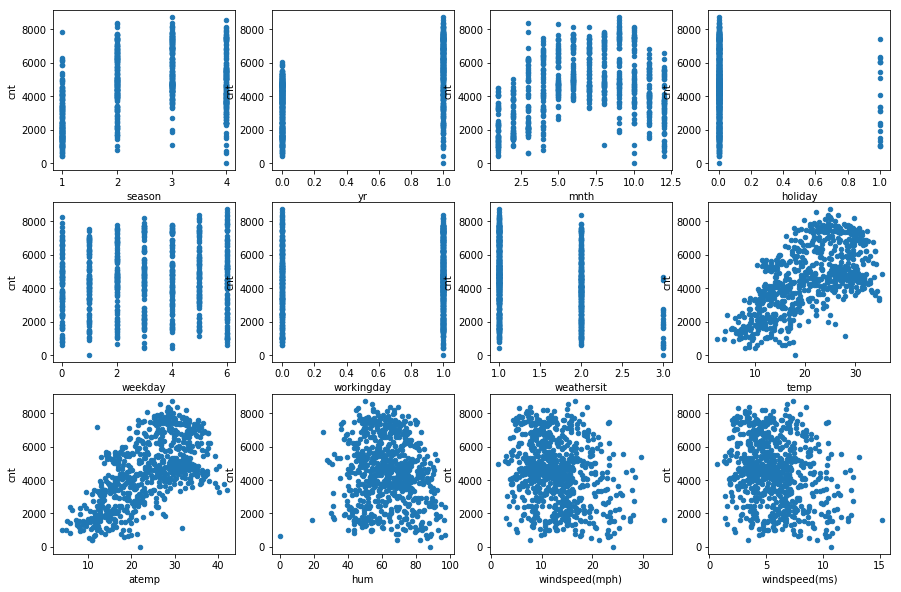

In [13]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 10))
for idx, feature in enumerate(df.columns[:-1]):
    df.plot(feature, "cnt", subplots=True, kind="scatter", ax=axes[idx // 4, idx % 4])

Давайте оценим уровень линейной зависимости между признаками и целевой переменной. Хорошей мерой линейной зависимости между двумя векторами является корреляция Пирсона. В pandas ее можно посчитать с помощью двух методов датафрейма: `corr` и `corrwith`. Метод `df.corr` вычисляет матрицу корреляций всех признаков из датафрейма. Методу `df.corrwith` нужно подать еще один датафрейм в качестве аргумента, и тогда он посчитает попарные корреляции между признаками из `df` и этого датафрейма.

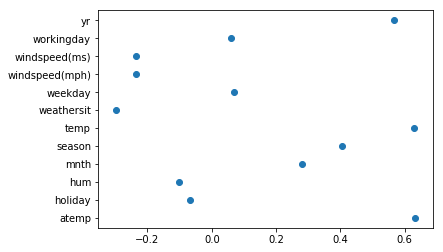

In [89]:
dfWC = df.drop('cnt', axis=1)
corr_matrix = dfWC.corrwith(df['cnt'])
plt.scatter(list(corr_matrix), dfWC.columns);

В выборке есть признаки, коррелирующие с целевым, а значит, задачу можно решать линейными методами.

По графикам видно, что некоторые признаки похожи друг на друга. Поэтому давайте также посчитаем корреляции между вещественными признаками.

In [91]:
import seaborn as sns

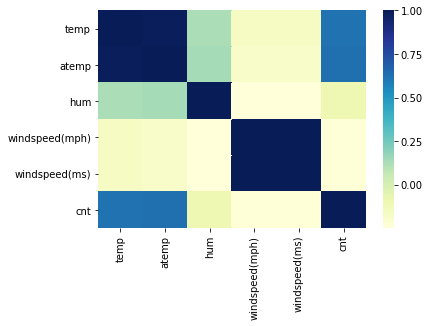

In [92]:
use = ['temp', 'atemp', 'hum', 'windspeed(mph)', 'windspeed(ms)','cnt']
df_new = df[use]

matrix = df_new.corr(method='pearson')
sns.heatmap(matrix, cmap="YlGnBu");

На диагоналях, как и полагается, стоят единицы. Однако в матрице имеются еще две пары сильно коррелирующих столбцов: `temp` и `atemp` (коррелируют по своей природе) и два `windspeed` (потому что это просто перевод одних единиц в другие). Далее мы увидим, что этот факт негативно сказывается на обучении линейной модели.

Посмотрите средние признаков (метод `mean`), чтобы оценить масштаб признаков и доли 1 у бинарных признаков.

In [26]:
df.mean()

season               2.496580
yr                   0.500684
mnth                 6.519836
holiday              0.028728
weekday              2.997264
workingday           0.683995
weathersit           1.395349
temp                20.310776
atemp               23.717699
hum                 62.789406
windspeed(mph)      12.762576
windspeed(ms)        5.705220
cnt               4504.348837
dtype: float64

Признаки имеют разный масштаб, значит для дальнейшей работы нам лучше нормировать матрицу объекты-признаки.

### Проблема первая: коллинеарные признаки

Итак, в наших данных один признак дублирует другой, и есть еще два очень похожих. Конечно, мы могли бы сразу удалить дубликаты, но давайте посмотрим, как бы происходило обучение модели, если бы мы не заметили эту проблему. 

Для начала проведем масштабирование, или стандартизацию признаков: из каждого признака вычтем его среднее и поделим на стандартное отклонение. Это можно сделать с помощью метода `scale`.

Кроме того, нужно перемешать выборку, это потребуется для кросс-валидации.

In [27]:
from sklearn.preprocessing import scale
from sklearn.utils import shuffle

In [28]:
df_shuffled = shuffle(df, random_state=123)
X = scale(df_shuffled[df_shuffled.columns[:-1]])
y = df_shuffled["cnt"]

Давайте обучим линейную регрессию на наших данных и посмотрим на веса признаков.

In [29]:
from sklearn.linear_model import LinearRegression

In [41]:
def printCoef(coef):
    for i in range(0, len(df.columns)-1):
        print(df.columns[i]+' '+str(coef[i]))

In [43]:
lr = LinearRegression()
lr.fit(X, y)
coef = lr.coef_
printCoef(coef)

season 570.8670901730774
yr 1021.9648978678127
mnth -141.30102875358523
holiday -86.76029852892623
weekday 137.2280569118011
workingday 56.39209620562903
weathersit -330.23041481656986
temp 367.48148905804925
atemp 585.5505407216319
hum -145.60907944330907
windspeed(mph) 12457303163886.324
windspeed(ms) -12457303164084.775


Мы видим, что веса при линейно-зависимых признаках по модулю значительно больше, чем при других признаках.

Чтобы понять, почему так произошло, вспомним аналитическую формулу, по которой вычисляются веса линейной модели в методе наименьших квадратов:

$w = (X^TX)^{-1} X^T y$.

Если в `X` есть коллинеарные (линейно-зависимые) столбцы, матрица $X^TX$ становится вырожденной, и формула перестает быть корректной. Чем более зависимы признаки, тем меньше определитель этой матрицы и тем хуже аппроксимация $Xw \approx y$. Такую ситуацию называют _проблемой мультиколлинеарности_.

С парой `temp-atemp` чуть менее коррелирующих переменных такого не произошло, однако на практике всегда стоит внимательно следить за коэффициентами при похожих признаках.

Решение проблемы мультиколлинеарности состоит в __регуляризации__ линейной модели. К оптимизируемому функционалу прибавляют L1 или L2 норму весов, умноженную на коэффициент регуляризации $\alpha$. В первом случае метод называется __Lasso__, а во втором — __Ridge__. 

Обучите регрессоры `Ridge` и `Lasso` с параметрами по умолчанию и убедитесь, что проблема с весами решилась.

In [40]:
from sklearn.linear_model import Lasso, Ridge

In [46]:
lasso = Lasso().fit(X, y)
lasso.fit(X, y)
coefL = lasso.coef_
printCoef(coefL)

season 560.2416160308867
yr 1019.4634940657195
mnth -128.73062703678738
holiday -86.15278133371125
weekday 137.34789390496329
workingday 55.212370641356586
weathersit -332.3698569623487
temp 376.3632362096977
atemp 576.5307935045521
hum -144.1291550034861
windspeed(mph) -197.1396894024865
windspeed(ms) -2.8049174615126408e-08


In [45]:
ridge = Ridge().fit(X, y)
ridge.fit(X, y)
coefR = ridge.coef_
printCoef(coefR)

season 563.0645722520123
yr 1018.9483787875288
mnth -131.87332028247235
holiday -86.74609799709249
weekday 138.00511117871906
workingday 55.903110375064564
weathersit -332.3497884990729
temp 386.45788919192705
atemp 566.3470470600494
hum -145.0713272986726
windspeed(mph) -99.25944108181888
windspeed(ms) -99.25944115431427


### Проблема вторая: неинформативные признаки

В отличие от L2-регуляризации, L1 обнуляет веса при некоторых признаках. 

Давайте пронаблюдаем, как меняются веса при увеличении коэффициента регуляризации $\alpha$ (в лекции коэффициент при регуляризаторе мог быть обозначен другой буквой).

In [51]:
alphas = np.arange(1, 500, 50)
coefs_lasso = np.zeros((alphas.shape[0], X.shape[1])) # матрица весов размера (число регрессоров) x (число признаков)
coefs_ridge = np.zeros((alphas.shape[0], X.shape[1]))
for i  in range(0, len(alphas)):
    lasso = Lasso(alpha=alphas[i])
    lasso.fit(X, y)
    coefs_lasso[i] = lasso.coef_
    ridge = Ridge(alpha=alphas[i])
    ridge.fit(X, y)
    coefs_ridge[i] = ridge.coef_

Визуализируем динамику весов при увеличении параметра регуляризации:

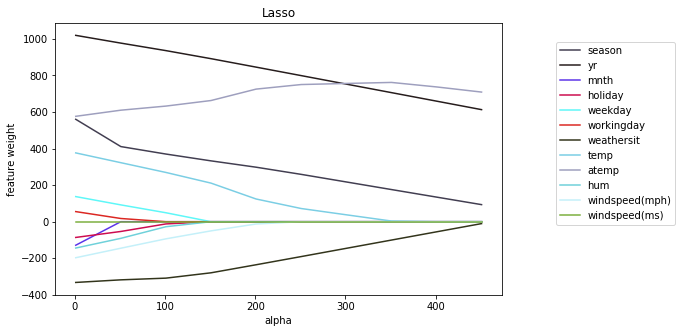

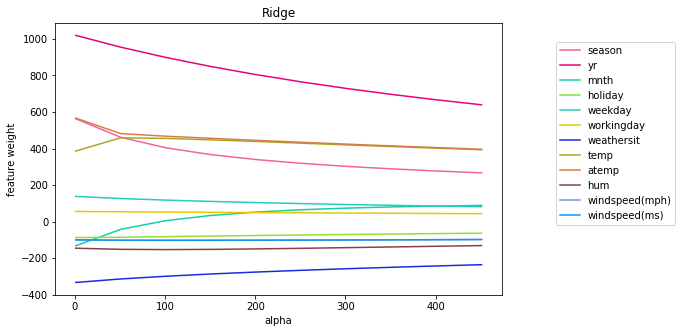

In [52]:
plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_lasso.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))
plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Lasso")

plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_ridge.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))
plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Ridge");

Далее будем работать с Lasso.

Итак, мы видим, что при изменении `alpha` модель по-разному подбирает коэффициенты признаков. Нам нужно выбрать наилучшее `alpha`. 

Для этого, во-первых, нам __нужна метрика качества__. Будем использовать в качестве метрики сам оптимизируемый функционал метода наименьших квадратов, то есть Mean Square Error.

Во-вторых, нужно понять, __на каких данных эту метрику считать__. Нельзя выбирать `alpha` по значению MSE на обучающей выборке, потому что тогда мы не сможем оценить, как модель будет делать предсказания на новых для нее данных. Если мы выберем одно разбиение выборки на обучающую и тестовую (это называется holdout), то настроимся на конкретные «новые» данные, и вновь можем переобучиться. Поэтому будем делать несколько разбиений выборки, на каждом пробовать разные значения `alpha`, а затем усреднять MSE. Удобнее всего делать такие разбиения кросс-валидацией, то есть разделить выборку на `K` частей, или блоков, и каждый раз брать одну из них как тестовую, а из оставшихся блоков составлять обучающую выборку. 

Делать кросс-валидацию для регрессии в sklearn совсем просто: для этого есть специальный регрессор, __LassoCV__, который берет на вход список из `alpha` и для каждого из них вычисляет MSE на кросс-валидации. После обучения (если оставить параметр cv=3 по умолчанию) регрессор будет содержать переменную __mse\_path\___, матрицу размера `len(alpha) x k`, `k = 3` (число блоков в кросс-валидации), содержащую значения MSE на тесте для соответствующих запусков. Кроме того, в переменной alpha\_ будет храниться выбранное значение параметра регуляризации, а в coef\_, традиционно, обученные веса, соответствующие этому alpha_.

Обратите внимание, что регрессор может менять порядок, в котором он проходит по `alphas`; для сопоставления с матрицей MSE лучше использовать переменную регрессора `alphas`.

In [50]:
from sklearn.linear_model import LassoCV

6
season 532.0189828413535
yr 1015.0602226430595
mnth -100.03952614356622
holiday -83.2939598752991
weekday 132.50446549095793
workingday 51.55708561407394
weathersit -330.55985673998117
temp 370.6798550300367
atemp 581.3969310654954
hum -140.0074055006889
windspeed(mph) -191.77140847135027
windspeed(ms) -2.6855024557067635e-08


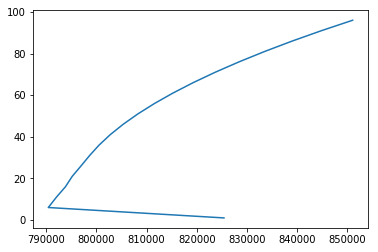

In [65]:
# Выведите выбранное alpha, а также пары "признак-коэффициент" для обученного вектора коэффициентов
alphas = np.arange(1, 100, 5)
CVlas = LassoCV(alphas = alphas, cv=3)
CVlas.fit(X, y)
mse = CVlas.mse_path_
x = np.zeros(len(mse))
for i in range(0, len(x)):
    x[i]=sum(mse[i])/len(mse[i])

plt.plot(x, CVlas.alphas_)

print(CVlas.alpha_)
coefCV = CVlas.coef_
printCoef(coefCV)

На каждом разбиении оптимальное значение alpha свое, и ему соответствует большое MSE на других разбиениях. Получается, что мы настраиваемся на конкретные обучающие и контрольные выборки. При выборе alpha на кросс-валидации мы выбираем нечто "среднее", что будет давать приемлемое значение метрики на разных разбиениях выборки. 

Наконец, как принято в анализе данных, давайте проинтерпретируем результат.

------

### Ответьте на вопросы :

1. В последней обученной модели выберите 4 признака с наибольшими (положительными) коэфициентами (и выпишите их), посмотрите на визуализации зависимостей cnt от этих признаков, которые мы рисовали в блоке «Знакомство с данными». Видна ли возрастающая линейная зависимость `cnt` от этих признаков по графикам? Логично ли утверждать (из здравого смысла), что чем больше значение этих признаков, тем больше людей захотят взять велосипеды? 
    * Ответ: наибольшие коэфиценты: season 532.0189828413535, yr 1015.0602226430595, temp 370.6798550300367,atemp 581.3969310654954. Если смотреть на визуализацию данных, то возрастание коэфициентов матрицы не совпадает с коэфициентами с обученой выборки. Так что данное умозаключение не логично.
1. Выберите 3 признака с наибольшими по модулю отрицательными коэффициентами (и выпишите их), посмотрите на соответствующие визуализации. Видна ли убывающая линейная зависимость? Логично ли утверждать, что чем больше величина этих признаков, тем меньше людей захотят взять велосипеды?
    * Ответ: weathersit -330.55985673998117, hum -140.0074055006889, windspeed(mph) -191.77140847135027. Если следовать этой логике, то можно утверждать, что чем больше по модулю отрицательные коэффициенты тем меньше людей захотят взять велосипеды.
1. Выпишите признаки с коэффициентами, близкими к нулю (< 1e-3). Как вы думаете, почему модель исключила их из модели (вновь посмотрите на графики)? Верно ли, что они никак не влияют на спрос на велосипеды?
    * Ответ: windspeed(ms) -2.6855024557067635e-08. Я думаю он был исключен из модели, потому что он очень коррелировал с признаком windspeed(mph), а как нам известно, то чем больше коррелируют между собою признаки - тем больше они похожи, а значит тем меньше несут нам полезной информации для постройки нашей модели.


------